# Adaptive Regret

The goal of this is to test how to use multiple copies of our algorithm underneath a layer of learning from experts.


## References
Here are some references so that I don't need to keep tabs open all the time:
- **"Adaptive Gradient Methods with Local Guarantees"** (SAMUEL), Hazan & Sanjeev 2023
    - https://arxiv.org/pdf/2203.01400.pdf
    - the way that multiplicative weights was done here is unique and worth looking at
    - havent finished yet
- **"On the Computational Efficiency of Adaptive and Dynamic Regret Minimization"**, Lu & Hazan 2023
    - https://arxiv.org/pdf/2207.00646.pdf
    - better FTH with $\log \log (T)$ experts

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 187006.95it/s]

13 16.643856189774723


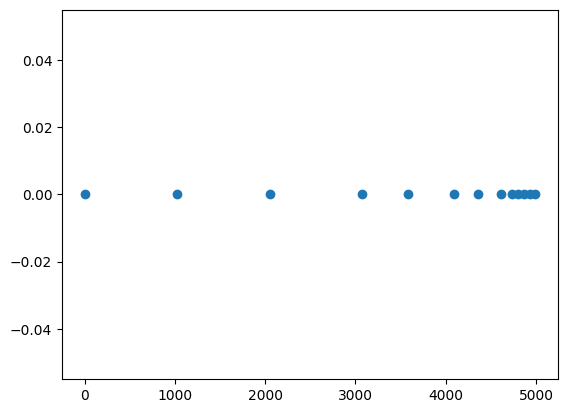

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

spawn_every = 64
life_lower_bound = 100
T0 = 6000
T = 5000

def generate_death_times(n, min_lifetime, first_lifetime=None):
    def lifetime(i):
        l = 4
        while i % 2 == 0:
            l *= 2
            i /= 2
        return max(l + 1, min_lifetime)

    tod = np.arange(n)
    for i in range(1, n):
        tod[i] = i + lifetime(i)
    if first_lifetime is None: first_lifetime = min_lifetime
    tod[0] = first_lifetime  # lifetime not defined for 0
    return tod
tod = generate_death_times(T, min_lifetime=life_lower_bound, first_lifetime=T0)

experts = {}
for i in tqdm.trange(T):
    if i % spawn_every == 0:
        experts[i] = True
    kill_idx = np.where(tod == i)[0]
    if len(kill_idx) and kill_idx[0] in experts:
        del experts[kill_idx[0]]

print(len(experts), 2 * np.log2(N))
plt.scatter(experts.keys(), [0 for _ in range(len(experts))])

In [ ]:
from typing import Callable

import numpy as np

from extravaganza.explorer import Explorer
from extravaganza.controllers import Controller
from extravaganza.system_models import Dataset
from extravaganza.stats import Stats


class HardFTH(Controller):
    def __init__(self,
                 control_dim: int, obs_dim: int,
                 explorer: Explorer,  # for an initial exploration before spawining the first expert
                 make_controller: Callable[[Dataset], Controller],  # to make controllers
                 
                 eta: float,
                 T0: int,
                 spawn_every: int,
                 dataset_window: int,
                 min_lifetime: int,
                 ):
        super().__init__()
        assert control_dim == explorer.control_dim
        self.control_dim = control_dim
        self.state_dim = obs_dim
        self.make_controller = make_controller
        
        self.t = 0
        self.min_lifetime = min_lifetime
        self.tod = generate_death_times(10 * max(min_lifetime, T0), min_lifetime, first_lifetime=T0)
        self.spawn_every = spawn_every
        self.dataset_window = dataset_window
        
        self.dataset = Dataset(self.control_dim, self.state_dim)
        self.experts = {0: explorer}  # list of active experts
        self.eta = eta
        self.probs = {0: 1.}
        self.prev_selected_expert = 0  # idx of expert that we selected last
        
        self.stats = Stats()
        self.stats.register('states', obj_class=np.ndarray, shape=(self.state_dim,))
        self.stats.register('disturbances', obj_class=np.ndarray, shape=(self.state_dim,))
        self.stats.register('-K @ state', obj_class=np.ndarray, shape=(self.control_dim,))
        self.stats.register('M \cdot w', obj_class=np.ndarray, shape=(self.control_dim,))
        self.stats.register('M0', obj_class=np.ndarray, shape=(self.control_dim,))
        pass
        
    def system_reset_hook(self):
        self.dataset.reset()
        for e in self.experts.values(): e.system_reset_hook()
        pass
    
    def update(self, state: np.ndarray, cost: float, control: np.ndarray, next_state: np.ndarray, next_cost: float):
        self.dataset.add_transition(state, cost, control, next_state, next_cost)
        ret = self.experts[self.prev_selected_expert].update(state, cost, control, next_state, next_cost)
        
        # decay prob
        self.probs[self.prev_selected_expert] *= np.exp(-self.eta * next_cost)
        
        # renormalize, and spawn a new expert if necessary
        if self.t % self.spawn_every == 0:
            v = (1 - 1 / self.t) / sum(self.probs.values())
            for k in self.probs.keys(): self.probs[k] *= v
            self.probs[self.t] = 1 / self.t
            self.experts[self.t] = make_controller(dataset.get_tail(self.dataset_window))
        else:
            v = 1 / sum(self.probs.values())
            for k in self.probs.keys(): self.probs[k] *= v
        assert np.allclose(sum(self.probs.values()), 1.)
        
        # kill whoever we have to
        kill_idx = np.where(self.tod == self.t)[0]
        if len(kill_idx) and kill_idx[0] in self.experts:
            del self.experts[kill_idx[0]]
            del self.probs[kill_idx[0]]
        
        return ret
    
    def get_control(self, cost: float, obs: np.ndarray) -> np.ndarray:
        assert obs.shape == (self.obs_dim,), (obs.shape, self.obs_dim)
        self.t += 1
        for e in self.experts.values(): e.t = self.t
        if self.t >= len(self.tod): self.tod = generate_death_times(2 * self.t, self.min_lifetime)
        self.prev_selected_expert = np.random.choice(list(self.probs.keys()), p=list(self.probs.values()))
        expert = self.experts[self.prev_selected_expert]
        control = expert.get_control(cost, obs)
        
        # collect the most recent stats from the selected expert
        if expert.stats is not None:
            s = expert.stats._stats
            keys = ['states', '-K @ state', 'M0', 'M \cdot w']
            for k in keys:
                if k in s: self.stats.update(k, s[k].values[-1], t=self.t)
        
        return control

In [ ]:
from collections import namedtuple
from typing import Callable, Tuple

from extravaganza.controllers import Controller
from extravaganza.sysid import SystemModel

Expert = namedtuple('Expert', ['controller',
                               'start_idx',
                               'stop_idx'])

class Dataset:
,,,,,,,,,,,,,,,,,,,,,,,,

class FTHRegression:
    def __init__(T: int,
                 make_controller: Callable[[Tuple[np.ndarray, np.ndarray]], Controller],  # makes a controller from a linear system model
                 control_dim: int,
                 obs_dim: int,
                 epsilon: float):
        
        self.T = T
        self.make_controller = make_controller
        self.control_dim, self.obs_dim = control_dim, obs_dim
        self.epsilon = epsilon
        
        self.sysid = sysid
        self.dataset = 
        
        
    